In [51]:
import wikipedia
import pandas as pd
import lxml.html as lh
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)

In [52]:
def get_museum_wikipedia_table(page_title):

    # try:
    page = wikipedia.page(page_title)
    page_html = page.html()
    # except wikipedia.WikipediaException as e:
    #     print(f"Error: {e}")

    #%%
    table = lh.fromstring(page_html)
    df = pd.read_html(page_html)[0]

    countries = table.xpath("//tr/td/span[@class='flagicon']/a/@title")  # TODO trouver comment <span class="flagicon">

    assert len(countries) == len(df)
    df['Country'] = countries

    df.rename(columns={"Country flag, city": "City"}, inplace=True)

    df.rename(columns={"Country flag, city" : "City"}, inplace=True)

    return df

def get_cities_table():
    cities_df = pd.read_html("https://worldpopulationreview.com/world-cities")[0]
    cities_df.rename(columns={"Name" : "City"}, inplace=True)

    CITIES_TO_RENAME = [
        ["Taibei", "Taipei"],
        ["Washington", "Washington, D.C."],
        ["New York", "New York City"],
        ["Rio De Janeiro", "Rio de Janeiro"],
        ["Xianyang Shaanxi", "Xi'an"],  # TODO To be verified that it is the same city.
        ["Taizhong", "Taichung"],  # TODO To be verified that it is the same city.
    ]

    COUNTRIES_TO_RENAME = [
        ["Republic Of Korea", "South Korea"],
        ["Russian Federation", "Russia"],
        ["China, Taiwan Province Of China", "Taiwan"],
    ]

    MISSING_CITIES = [
        {"City":"Oświęcim", "Country":"Poland", "2020 Population":39057},  # https://en.wikipedia.org/wiki/O%C5%9Bwi%C4%99cim
        {"City":"Vatican City", "Country":"Vatican City", "2020 Population":618},  # https://www.vaticanstate.va/it/stato-governo/note-generali/popolazione.html
    ]


    for old_name, new_name in CITIES_TO_RENAME:
        cities_df.loc[cities_df.City==old_name, "City"] = new_name

    for old_name, new_name in COUNTRIES_TO_RENAME:
        cities_df.loc[cities_df.Country==old_name, "Country"] = new_name

    for c in MISSING_CITIES:
        cities_df = cities_df.append(c, ignore_index=True)

    # Remove Suzhou double entry, keeping the biggest

    print(cities_df[cities_df.City=="Suzhou"])

    print(len(cities_df))
    cities_df.drop_duplicates(subset="City", keep="first", inplace=True)
    print(len(cities_df))

    return cities_df

Load tables



In [53]:
museums_df = get_museum_wikipedia_table("List_of_most_visited_museums")
# museums_df

In [54]:
cities_df = get_cities_table()
# list(sorted(set(cities_df.City)))
# cities_df



      Rank    City Country  2020 Population  2019 Population Change
53    54.0  Suzhou   China          7069992        6703499.0  5.47%
440  441.0  Suzhou   China          1169932        1119054.0  4.55%
1149
1141


In [55]:
# Make sure all countries from museums_df are present in cities_df
museum_df_countries = set(museums_df.Country)
cities_df_countries= set(cities_df.Country)
diff = museum_df_countries - cities_df_countries
if len(diff) > 0:
    print("Missing cities info :")
    print(museums_df.query("City not in @cities_df.City"))
    print(diff)
    raise ValueError("Missing city info. A country from the museum list cannot be found in the cities list.", diff )


Merge museums with cities table

In [56]:
result_df = pd.merge(museums_df, cities_df, how="left", left_on=["City", "Country"], right_on=["City", "Country"] )
# result_df


In [57]:
db = result_df[["Name", "City", "Country", "Visitors per year", "2020 Population"]].copy()
db.rename(columns={"2020 Population" : "Population"}, inplace=True)
db
db.to_html("db.html")

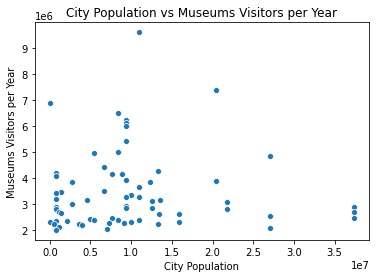

In [58]:
sns.scatterplot(x="Population", y="Visitors per year", data=db)
plt.title("City Population vs Museums Visitors per Year")
plt.xlabel("City Population")
plt.ylabel("Museums Visitors per Year")

plt.savefig("plot.png")

In [59]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
X = db[["Population"]]
# X = db[["Population", "Visitors per year"]]
y = db["Visitors per year"]

model.fit(X, y)

# model.predict([11017230])

print(f"{model.coef_=}")
print(f"{model.intercept_=}")


model.coef_=array([0.00108382])
model.intercept_=3462426.2088096254


<AxesSubplot:xlabel='Population', ylabel='Visitors per year'>

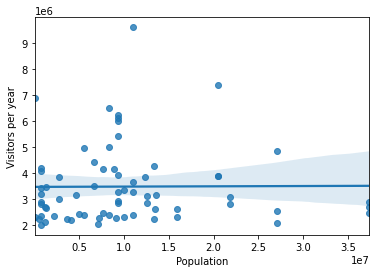

In [60]:
sns.regplot("Population", "Visitors per year", data=db)


Test prediction

In [61]:
model.predict([[100000]])

array([3462534.59041218])

In [62]:
# X
#

In [63]:
# y


